### Описание датасета:

__data_orders.csv:__
* order_datetime	-               время заказа
* origin_longitude	-             долгота
* origin_latitude	-               широта
* m_order_eta	-                   время до прибытия машины
* order_gk	-                     номер заказа
* order_status_key	статус -      (4 - отменен клиентом, 9 - отменен системой (reject))
* is_driver_assigned_key	-       был ли назначен водитель
* cancellations_time_in_seconds	- сколько секунд прошло до отмены


## Подготовим данные, подключим необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from matplotlib import rcParams
rcParams['axes.titlepad'] = 25
drive.mount('/content/drive')

In [3]:
orders = pd.read_csv('drive/MyDrive/datasets/gett_data/data_orders.csv')

In [4]:
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [5]:
orders.shape

(10716, 8)

In [6]:
orders.dtypes

order_datetime                    object
origin_longitude                 float64
origin_latitude                  float64
m_order_eta                      float64
order_gk                           int64
order_status_key                   int64
is_driver_assigned_key             int64
cancellations_time_in_seconds    float64
dtype: object

In [7]:
orders.isna().mean().mul(100).round(2)
# 73 % пропущенных наблюдений в колонках 'm_order_eta' (время до прибытия машины)
# 31 % пропущенных наблюдений в колонках 'cancellations_time_in_seconds' (сколько секунд прошло до отмены)

order_datetime                    0.00
origin_longitude                  0.00
origin_latitude                   0.00
m_order_eta                      73.74
order_gk                          0.00
order_status_key                  0.00
is_driver_assigned_key            0.00
cancellations_time_in_seconds    31.81
dtype: float64

## Посмотрим на распределение заказов по причинам неуспеха: отмены до и после назначения водителя

In [8]:
# distribution of cancellations
orders['order_status_key'].value_counts(normalize=True)

4    0.681878
9    0.318122
Name: order_status_key, dtype: float64

In [9]:
# группировка по статусу отмены, был ли назначен водитель
orders \
                    .groupby(['order_status_key', 'is_driver_assigned_key']) \
                    .agg({'order_gk': 'count'}) \
                    .reset_index()

,order_status_key,is_driver_assigned_key,order_gk
0,4,0,4496
1,4,1,2811
2,9,0,3406
3,9,1,3


In [10]:
# проверка на корректность
orders \
                    .groupby(['order_status_key', 'is_driver_assigned_key']) \
                    .agg({'order_gk': 'count'}) \
                    .reset_index() \
                    .order_gk.sum() == orders.shape[0]

True

In [11]:
# отбор статуса-отмены пользователем
cans_status_4 = orders \
                    .groupby(['order_status_key', 'is_driver_assigned_key']) \
                    .agg({'order_gk': 'count'}) \
                    .reset_index() \
                    .head(2)

In [12]:
# отбор статуса-отмены системой
cans_status_9 = orders \
                    .groupby(['order_status_key', 'is_driver_assigned_key']) \
                    .agg({'order_gk': 'count'}) \
                    .reset_index() \
                    .query('order_status_key == 9')
cans_status_9

,order_status_key,is_driver_assigned_key,order_gk
2,9,0,3406
3,9,1,3


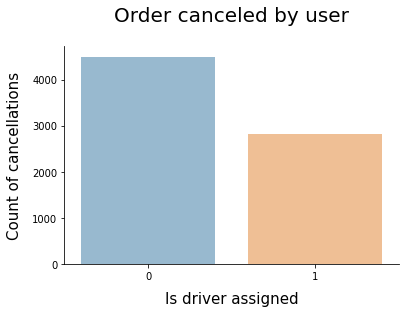

In [13]:
# распределение отмен пользователями

sns.barplot(
    x='is_driver_assigned_key',
    y='order_gk',
    data=cans_status_4,
    alpha = 0.5
    )

plt.xlabel("Is driver assigned", size=15, labelpad=10)
plt.ylabel("Count of cancellations", size=15, labelpad=10)
plt.title("Order canceled by user", size=20)
sns.despine();

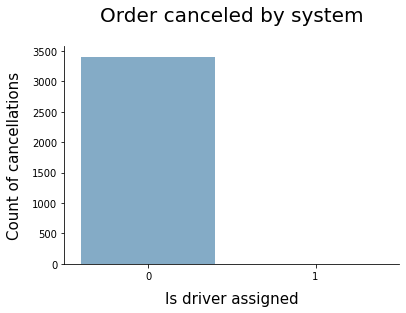

In [14]:
# распределение отмен системой

sns.barplot(
    x='is_driver_assigned_key',
    y='order_gk',
    data=cans_status_9,
    alpha = 0.6
    )

plt.xlabel("Is driver assigned", size=15, labelpad=10)
plt.ylabel("Count of cancellations", size=15, labelpad=10)
plt.title("Order canceled by system", size=20)
sns.despine();

In [15]:
no_driver = orders.query('is_driver_assigned_key == 0').groupby('order_status_key').agg({'order_gk': 'count'}).reset_index()

In [16]:
no_driver['distribution'] = no_driver['order_gk'] / no_driver['order_gk'].sum()

In [17]:
with_driver = orders.query('is_driver_assigned_key == 1').groupby('order_status_key').agg({'order_gk': 'count'}).reset_index()

In [18]:
with_driver['distribution'] = with_driver['order_gk'] / with_driver['order_gk'].sum()

In [19]:
print(no_driver['distribution'].round(3))
print(with_driver['distribution'].round(3))

0    0.569
1    0.431
Name: distribution, dtype: float64
0    0.999
1    0.001
Name: distribution, dtype: float64


* Если водитель назначен, то отмена происходит по иннициативе клиента в 57% случаях, система отменяет 43% заказов.
* Если водитель __не__ назначен, то отмена происходит по иннициативе клиента в 99% случаях, система отменяет 0.1% заказов.

## Посмотрим на долю отмен по инициативе системы в разрезе суток (reject by hours)

In [20]:
orders['hour'] = orders['order_datetime'].str[:2]

In [21]:
# добавим бинарный столбец 'reject', где 1 - это отмена по инициативе системы, 0 - пользователем
orders['reject'] = orders['order_status_key']

In [22]:
def syst_cans(x):
  if x == 9:
    return 1
  else:
    return 0

In [23]:
orders['reject'] = orders['reject'].apply(syst_cans)

In [24]:
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour,reject
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18,0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20,0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12,0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13,0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,21,1


In [25]:
# 'cansel_cnt' - кол-во отмен по часам, 'reject_percent' - доля реджектов по часам (отмен по инициативе системы)
by_hours_gr = orders \
                  .groupby(['hour']) \
                  .agg({'origin_latitude': 'count', 'reject': 'mean'}) \
                  .reset_index() \
                  .rename(columns={
                      'origin_latitude': 'cansel_cnt',
                      'reject': 'reject_percent',
                      })
by_hours_gr.head()

,hour,cansel_cnt,reject_percent
0,00,683,0.387994
1,01,471,0.348195
2,02,555,0.432432
3,03,513,0.438596
4,04,152,0.401316


In [26]:
# добавим бинарный столбец 'user_cans', где 1 - это отмена по инициативе пользователя, 0 - системы
orders['user_cans'] = orders['order_status_key']

In [27]:
def user_cans(x):
  if x == 4:
    return 1
  else:
    return 0

In [28]:
orders['user_cans'] = orders['user_cans'].apply(user_cans)

In [29]:
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour,reject,user_cans
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18,0,1
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20,0,1
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12,0,1
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13,0,1
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,21,1,0


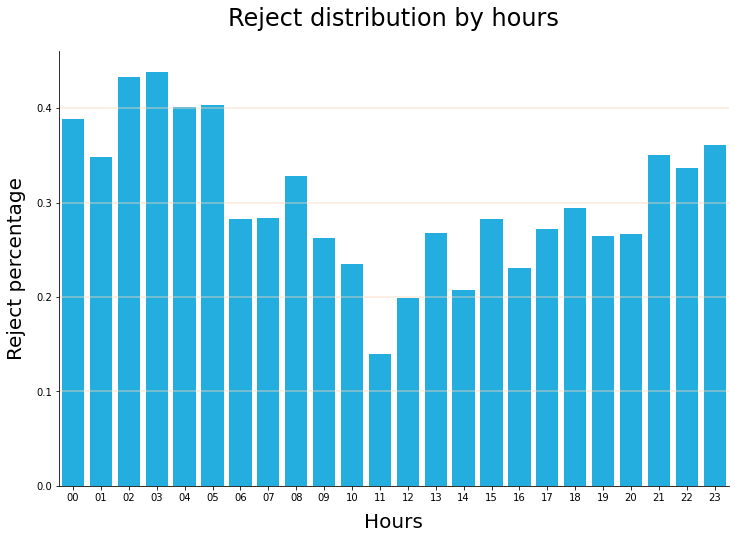

In [30]:
# график распределения реджектов по часам

plt.figure(figsize=(12,8))

sns.barplot().axhline(0.1, color='#FED6BC', alpha=0.5)
sns.barplot().axhline(0.2, color='#FED6BC', alpha=0.5)
sns.barplot().axhline(0.3, color='#FED6BC', alpha=0.5)
sns.barplot().axhline(0.4, color='#FED6BC', alpha=0.5)

sns.barplot(x='hour', 
            y="reject_percent", 
            data=by_hours_gr, 
            color='#00BCFF', 
            alpha=0.99)

plt.xlabel("Hours", size=20, labelpad=10)
plt.ylabel("Reject percentage", size=20, labelpad=10)
plt.title("Reject distribution by hours", size=24)

sns.despine()

На графике выше видно, что доля отмен по инициативе системы выше всего с 02 ночи до 05 часов утра, это может  быть связано, вероятно, с недостатком водителей в ночное время суток.

## Посмотрим на данные среднего времени до отмены заказа по часам, где водитель был назначен/не был назначен

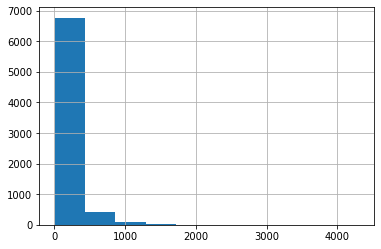

In [31]:
orders['cancellations_time_in_seconds'].hist();

In [32]:
ord_decsr = orders['cancellations_time_in_seconds'].describe()
ord_decsr

count    7307.000000
mean      157.892021
std       213.366963
min         3.000000
25%        45.000000
50%        98.000000
75%       187.500000
max      4303.000000
Name: cancellations_time_in_seconds, dtype: float64

In [33]:
# в столбце 'cancellations_time_in_seconds' есть выбросы, воспользуемся медианой, которая более устойчива к ним
# отберем медианное значение времени отменены заказов по часам, где водитель не был назначен
avg_time_cans_driv_0 = orders \
                                      .query('is_driver_assigned_key == 0') \
                                      .groupby('hour') \
                                      .agg({'cancellations_time_in_seconds': 'median'}) \
                                      .round(2) \
                                      .reset_index() \
                                      .rename(columns={'cancellations_time_in_seconds': 'cans_time_med_sec'})

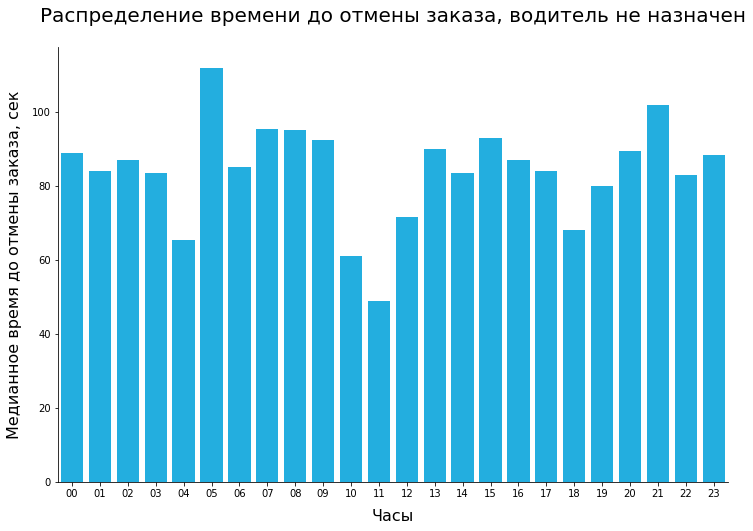

In [34]:
# распределение времени до отмены заказа по часам, водитель не был назначен
plt.figure(figsize=(12,8))

sns.barplot(x='hour', 
            y="cans_time_med_sec", 
            data=avg_time_cans_driv_0, 
            color='#00BCFF', 
            alpha=0.99)

plt.xlabel("Часы", size=16, labelpad=10)
plt.ylabel("Медианное время до отмены заказа, сек", size=16, labelpad=10)
plt.title("Распределение времени до отмены заказа, водитель не назначен", size=20)

sns.despine()

In [35]:
# отберем медианное значение времени отменены заказов по часам, где водитель был назначен
avg_time_cans_driv_1 = orders \
                                      .query('is_driver_assigned_key == 1') \
                                      .groupby('hour') \
                                      .agg({'cancellations_time_in_seconds': 'median'}) \
                                      .round(2) \
                                      .reset_index() \
                                      .rename(columns={'cancellations_time_in_seconds': 'cans_time_med_sec'})

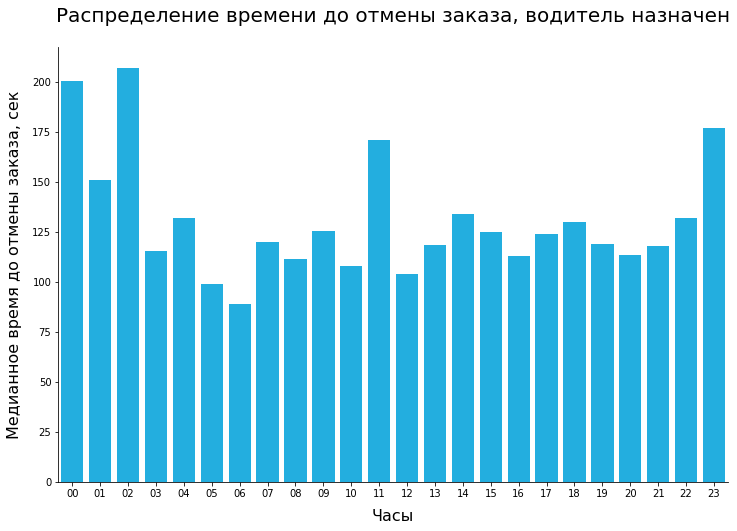

In [36]:
# распределение времени до отмены заказа по часам, водитель назначен
plt.figure(figsize=(12,8))

sns.barplot(x='hour', 
            y="cans_time_med_sec", 
            data=avg_time_cans_driv_1, 
            color='#00BCFF', 
            alpha=0.99)

plt.xlabel("Часы", size=16, labelpad=10)
plt.ylabel("Медианное время до отмены заказа, сек", size=16, labelpad=10)
plt.title("Распределение времени до отмены заказа, водитель назначен", size=20)
sns.despine()

In [37]:
# сводка по медианному времени отмены заказов в зависимости от того был/не был назначен водитель
orders \
    .groupby('is_driver_assigned_key') \
    .agg({'cancellations_time_in_seconds': 'median'}) \
    .reset_index()

,is_driver_assigned_key,cancellations_time_in_seconds
0,0,88.0
1,1,127.0


Оба графика выше имеют распределение, похожее на равномерное 

Медианное время отмены заказа сильно меньше в случае, когда пользователю не назначается водитель.

## Взглянем на данные по ETA (estimated time of arrival) водителя к месту, указанному пользователем

In [38]:
orders['m_order_eta'].describe()

count    2814.000000
mean      441.415423
std       288.006379
min        60.000000
25%       233.000000
50%       368.500000
75%       653.000000
max      1559.000000
Name: m_order_eta, dtype: float64

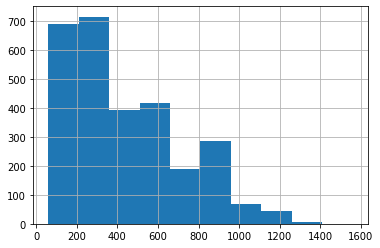

In [39]:
orders['m_order_eta'].hist()

In [40]:
eta_by_hours_med = orders \
                      .groupby('hour') \
                      .agg({'m_order_eta': 'median'}) \
                      .divide(60) \
                      .round(2) \
                      .reset_index() \
                      .rename(columns={'m_order_eta': 'median_eta'})

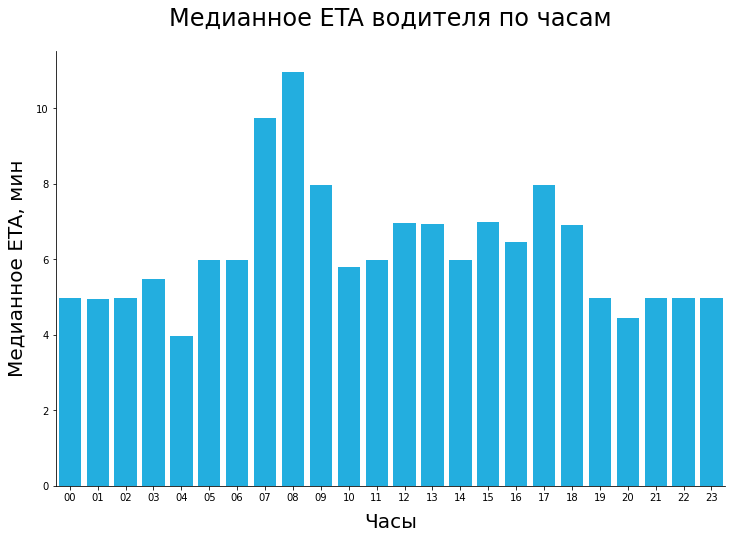

In [41]:
# распределение медианного времени ожидаемого времени прибытия водителя в разрезе суток
plt.figure(figsize=(12,8))

sns.barplot(x='hour', 
            y="median_eta", 
            data=eta_by_hours_med, 
            color='#00BCFF', 
            alpha=0.99)

plt.xlabel("Часы", size=20, labelpad=10)
plt.ylabel("Медианное ETA, мин", size=20, labelpad=10)
plt.title("Медианное ETA водителя по часам", size=24)

sns.despine()

На графике распределения среднего ETA по часам мы видим пики, которые приходятся на:
* утренние часы-пик: 07-09 утра;
* вечерний час: 17 вечера.

Объяснить это можно увеличивающимся спросом в связи со временем, когда люди едут на работу или уезжают с нее.